In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

from src.test_hmm import simulate_poisson_spikes
from scipy.stats import multivariate_normal, norm


def simulate_time(n_samples, sampling_frequency):
    return np.arange(n_samples) / sampling_frequency


def simulate_position(time, track_height, running_speed=10):
    half_height = track_height / 2
    return (
        half_height * np.sin(2 * np.pi * time / running_speed - np.pi / 2) + half_height
    )


def create_place_field(
    place_field_mean,
    position,
    sampling_frequency,
    is_condition=None,
    place_field_std_deviation=12.5,
    max_firing_rate=20,
    baseline_firing_rate=0.001,
):
    if is_condition is None:
        is_condition = np.ones_like(position, dtype=bool)
    field_firing_rate = norm(place_field_mean, place_field_std_deviation).pdf(position)
    field_firing_rate /= np.nanmax(field_firing_rate)
    field_firing_rate[~is_condition] = 0
    return baseline_firing_rate + max_firing_rate * field_firing_rate


def simulate_place_field_firing_rate(
    means, position, max_rate=15, variance=10, is_condition=None
):
    """Simulates the firing rate of a neuron with a place field at `means`.

    Parameters
    ----------
    means : ndarray, shape (n_position_dims,)
    position : ndarray, shape (n_time, n_position_dims)
    max_rate : float, optional
    variance : float, optional
    is_condition : None or ndarray, (n_time,)

    Returns
    -------
    firing_rate : ndarray, shape (n_time,)

    """
    if is_condition is None:
        is_condition = np.ones(position.shape[0], dtype=bool)
    firing_rate = multivariate_normal(means, variance).pdf(position)
    firing_rate /= firing_rate.max()
    firing_rate *= max_rate
    firing_rate[~is_condition] = 0.0

    return firing_rate


def simulate_neuron_with_place_field(
    means, position, max_rate=15, variance=36, sampling_frequency=500, is_condition=None
):
    """Simulates the spiking of a neuron with a place field at `means`.

    Parameters
    ----------
    means : ndarray, shape (n_position_dims,)
    position : ndarray, shape (n_time, n_position_dims)
    max_rate : float, optional
    variance : float, optional
    sampling_frequency : float, optional
    is_condition : None or ndarray, (n_time,)

    Returns
    -------
    spikes : ndarray, shape (n_time,)

    """
    firing_rate = simulate_place_field_firing_rate(
        means, position, max_rate, variance, is_condition
    )
    return simulate_poisson_spikes(firing_rate, sampling_frequency)


def get_trajectory_direction(position):
    is_inbound = np.insert(np.diff(position) < 0, 0, False)
    return np.where(is_inbound, "Inbound", "Outbound"), is_inbound


def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with
    given mean and sigma."""
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * np.sqrt(2.0 * np.pi))


def estimate_position_distance(
    place_bin_centers: np.ndarray,
    positions: np.ndarray,
    position_std: np.ndarray,
) -> np.ndarray:
    """Estimates the Euclidean distance between positions and position bins.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : array_like, shape (n_position_dims,)

    Returns
    -------
    position_distance : np.ndarray, shape (n_time, n_position_bins)

    """
    n_time, n_position_dims = positions.shape
    n_position_bins = place_bin_centers.shape[0]

    position_distance = np.ones((n_time, n_position_bins), dtype=np.float32)

    if isinstance(position_std, (int, float)):
        position_std = [position_std] * n_position_dims

    for position_ind, std in enumerate(position_std):
        position_distance *= gaussian_pdf(
            np.expand_dims(place_bin_centers[:, position_ind], axis=0),
            np.expand_dims(positions[:, position_ind], axis=1),
            std,
        )

    return position_distance


def estimate_position_density(
    place_bin_centers: np.ndarray,
    positions: np.ndarray,
    position_std: np.ndarray,
    block_size: int = 100,
    sample_weights: np.ndarray = None,
) -> np.ndarray:
    """Estimates a kernel density estimate over position bins using
    Euclidean distances.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : float or array_like, shape (n_position_dims,)
    sample_weights : None or np.ndarray, shape (n_time,)

    Returns
    -------
    position_density : np.ndarray, shape (n_position_bins,)

    """
    n_position_bins = place_bin_centers.shape[0]

    if block_size is None:
        block_size = n_position_bins

    position_density = np.empty((n_position_bins,))
    for start_ind in range(0, n_position_bins, block_size):
        block_inds = slice(start_ind, start_ind + block_size)
        position_density[block_inds] = np.average(
            estimate_position_distance(
                place_bin_centers[block_inds], positions, position_std
            ),
            axis=0,
            weights=sample_weights,
        )
    return position_density


def get_firing_rate(
    is_spike: np.ndarray,
    position: np.ndarray,
    place_bin_centers: np.ndarray,
    is_track_interior: np.ndarray,
    not_nan_position: np.ndarray,
    occupancy: np.ndarray,
    position_std: np.ndarray,
    block_size: int = None,
    weights: np.ndarray = None,
) -> np.ndarray:
    if is_spike.sum() > 0:
        mean_rate = np.average(is_spike, weights=weights)
        marginal_density = np.zeros((place_bin_centers.shape[0],), dtype=np.float32)

        marginal_density[is_track_interior] = estimate_position_density(
            place_bin_centers[is_track_interior],
            np.asarray(
                position[is_spike.astype(bool) & not_nan_position], dtype=np.float32
            ),
            position_std,
            block_size=block_size,
            sample_weights=np.asarray(
                weights[is_spike.astype(bool) & not_nan_position], dtype=np.float32
            ),
        )
        return np.spacing(1) + (mean_rate * marginal_density / occupancy)
    else:
        return np.zeros_like(occupancy)


def simulate_two_state_poisson(n_time=20_000, sampling_frequency=1000):

    rate = 5.0 * np.ones((n_time,))
    rate[(n_time // 6) : (2 * n_time // 6)] = 20.0
    rate[(4 * n_time // 6) : (6 * n_time // 6)] = 20.0

    time = np.arange(n_time) / sampling_frequency
    spikes = simulate_poisson_spikes(rate, sampling_frequency)

    return time, rate, spikes


def poisson_log_likelihood(spikes, rate):
    return poisson.logpmf(spikes, mu=rate + np.spacing(1))


In [8]:
track_height = 170
sampling_frequency = 500
n_samples = sampling_frequency * 240

time = simulate_time(n_samples, sampling_frequency)
position = simulate_position(time, track_height)[:, np.newaxis]

trajectory_direction, is_inbound = get_trajectory_direction(position.squeeze())
spikes = simulate_neuron_with_place_field(
    [50],
    position,
    max_rate=30,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Inbound"),
) + simulate_neuron_with_place_field(
    [150],
    position,
    max_rate=10,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Outbound"),
)


In [9]:
place_bin_centers = position
is_track_interior = np.ones((place_bin_centers.shape[0],), dtype=bool)
not_nan_position = np.ones((len(time),), dtype=bool)
position_std = 6.0

occupancy = np.zeros((place_bin_centers.shape[0],), dtype=np.float32)
occupancy[is_track_interior] = estimate_position_density(
    place_bin_centers[is_track_interior],
    position[not_nan_position],
    position_std,
)
weights = np.ones_like(position).squeeze()

estimated_rate = get_firing_rate(
    spikes,
    position,
    place_bin_centers,
    is_track_interior,
    not_nan_position,
    occupancy,
    6.0,
    weights=weights,
)
# plt.plot(place_bin_centers, estimated_rate * sampling_frequency)
# plt.eventplot(position[np.nonzero(spikes)[0]].squeeze(), color='red');


(0.0, 50.0)

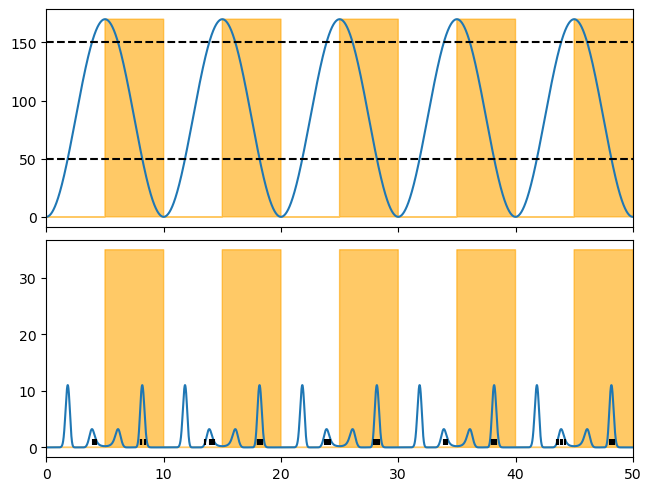

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, constrained_layout=True)
axes[0].plot(time, position)
axes[0].fill_between(time, is_inbound * position.max(), color="orange", alpha=0.6)

axes[0].axhline(50, color="black", linestyle="--")
axes[0].axhline(150, color="black", linestyle="--")

axes[1].plot(time, estimated_rate * sampling_frequency)
axes[1].fill_between(time, is_inbound * 35, color="orange", alpha=0.6)

spike_time_ind = np.nonzero(spikes)[0]
axes[1].eventplot(time[spike_time_ind], color="black")

plt.xlim((0, 50))


In [11]:
from src.hmm import poisson_log_likelihood

log_likelihood = poisson_log_likelihood(spikes, estimated_rate)


In [26]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
)

import matplotlib.pyplot as plt


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02], [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0

while not converged and (n_iter < max_iter):
    place_bin_centers = position
    is_track_interior = np.ones((place_bin_centers.shape[0],), dtype=bool)
    not_nan_position = np.ones((len(time),), dtype=bool)
    position_std = 6.0

    occupancy1 = np.zeros((place_bin_centers.shape[0],), dtype=np.float32)
    occupancy1[is_track_interior] = estimate_position_density(
        place_bin_centers[is_track_interior],
        position[not_nan_position],
        position_std,
        sample_weights=is_training.astype(float),
    )

    estimated_rate1 = get_firing_rate(
            spikes,
            position,
            place_bin_centers,
            is_track_interior,
            not_nan_position,
            occupancy,
            6.0,
            weights=is_training.astype(float),
    )

    occupancy2 = np.zeros((place_bin_centers.shape[0],), dtype=np.float32)
    occupancy2[is_track_interior] = estimate_position_density(
        place_bin_centers[is_track_interior],
        position[not_nan_position],
        position_std,
        sample_weights=1 - is_training.astype(float),
    )
    
    estimated_rate2 = get_firing_rate(
            spikes,
            position,
            place_bin_centers,
            is_track_interior,
            not_nan_position,
            occupancy2,
            6.0,
            weights=1 - is_training.astype(float),
    )
    
    estimated_rate = np.stack([estimated_rate1, estimated_rate2], axis=1)
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], estimated_rate))

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)


    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]


    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]

iteration 2, likelihood: -1848.2107162182313, change: 1.4121499475145356
iteration 3, likelihood: -1841.4290755611653, change: 6.781640657065964
iteration 4, likelihood: -1824.824966923358, change: 16.604108637807258
iteration 5, likelihood: -1805.282237861263, change: 19.542729062095077
iteration 6, likelihood: -1792.058271594696, change: 13.223966266567004
iteration 7, likelihood: -1784.5047208273836, change: 7.553550767312345
iteration 8, likelihood: -1779.6573157711302, change: 4.847405056253365
iteration 9, likelihood: -1776.0043790268712, change: 3.652936744259023
iteration 10, likelihood: -1772.9951145183866, change: 3.009264508484648
iteration 11, likelihood: -1770.4179673981184, change: 2.577147120268137
iteration 12, likelihood: -1768.1616073203813, change: 2.2563600777370993
iteration 13, likelihood: -1766.1507086324539, change: 2.0108986879274653
iteration 14, likelihood: -1764.3304503133554, change: 1.820258319098457
iteration 15, likelihood: -1762.6604929091034, change: 1

KeyboardInterrupt: 